In [1]:

import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import time
import pandas as pd
import numpy as np


import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

snb_stemmer_ru = SnowballStemmer('russian')
ru_stop_words = stopwords.words('russian')
# morph = pymorphy2.MorphAnalyzer()


In [2]:
def get_data(data_path):
    data_csv = (pd.read_csv(data_path)) 
    mask = data_csv['0'].notna()
    data_csv = list(data_csv[mask]['0'])
    return data_csv

In [3]:
pred_cultural_lst = get_data('pred_cultural_lst.csv')
pred_economic_lst = get_data('pred_economic_lst.csv')
pred_politics_lst = get_data('pred_politics_lst.csv')
pred_science_lst = get_data('pred_science_lst.csv')
pred_society_lst = get_data('pred_society_lst.csv')
pred_sport_lst = get_data('pred_sport_lst.csv')

In [4]:
len(pred_cultural_lst), len(pred_economic_lst), len(pred_politics_lst), len(pred_science_lst), len(pred_society_lst), len(pred_sport_lst)

(31998, 32000, 33220, 31999, 27560, 31985)

In [5]:
pred_cultural_lst = pred_cultural_lst[:17000]
pred_economic_lst = pred_economic_lst[:17000]
pred_politics_lst = pred_politics_lst[:17000]
pred_science_lst = pred_science_lst[:17000]
pred_society_lst = pred_society_lst[:17000]
pred_sport_lst = pred_sport_lst[:17000]

In [6]:
dicted_data = {
    "category":[],
    "text":[] }

In [7]:
def creating_df(lst, category):
    
    for i in range(len(lst)):
        dicted_data["category"].append(category)
    dicted_data["text"].extend(lst)

In [8]:
creating_df(pred_politics_lst, "politics")
creating_df(pred_society_lst, "society")
creating_df(pred_sport_lst, "sport")
creating_df(pred_cultural_lst, "cultural")
creating_df(pred_science_lst, "science")
creating_df(pred_economic_lst, "economic")

In [9]:
df = pd.DataFrame(dicted_data)
df

,category,text
0,politics,начало расследование российский вмешательство ...
1,politics,минобороны опубликовать видео полёт российский...
2,politics,житель великобритания платить семь евро посеще...
3,politics,россиянка мария бутин судить сша обвинение уча...
4,politics,пентагон проигнорировать обращение министр обо...
...,...,...
101995,economic,российский бизнесмен выводить свой актив велик...
101996,economic,европейский бизнес заинтересованный инвестиция...
101997,economic,валюта сразу несколько развивающийся страна ук...
101998,economic,украина ощущать сокращение реверсный поставка ...


In [10]:
df['category'].value_counts()

category
politics    17000
society     17000
sport       17000
cultural    17000
science     17000
economic    17000
Name: count, dtype: int64

In [11]:
vectorizer = CountVectorizer(min_df=0.001, max_df=0.8)
X = df['text']
x_fit = vectorizer.fit(X)
X = x_fit.transform(X)
X = X.toarray()

In [12]:
bow = vectorizer.get_feature_names_out()

In [13]:
bow

array(['аарон', 'аборт', 'абрамс', ..., 'ёлка', 'ёмкость', 'ёнхап'],
      dtype=object)

In [14]:
# np.save('x_fit', x_fit)

In [15]:
# np.save('bow', bow)

In [16]:
le = LabelEncoder()
y = df['category']
encoder = le.fit(y) # применить label encoding
y = le.transform(y)

In [17]:
# politics = 2
# economic = 1
# society = 4
# sport = 5
# cultural = 0
# science = 3

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [19]:
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X)) 
        self.y = torch.nn.functional.one_hot(torch.tensor(list(y)).long(), num_classes = 6)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx): 
        return self.X[idx].float(), self.y[idx].float()


In [20]:
BATCH_SIZE = 1024 

train_dataset = NewsDataset(X_train, y_train) 
test_dataset = NewsDataset(X_test, y_test)


valid_ratio = 0.2 
num_valid =  int(valid_ratio * len(train_dataset)) 
num_train = len(train_dataset) - num_valid

train_dataset, valid_dataset = random_split(dataset=train_dataset, lengths=[num_train, num_valid])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

In [21]:
len(train_loader), len(valid_loader), len(test_loader)

(64, 16, 20400)

In [22]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_embeddings, embedding_dim):
        super(NeuralNet, self).__init__()

        self.rnn1 = torch.nn.RNN(input_size, 384)
        self.relu1 = nn.ReLU()
        
        self.rnn2 = torch.nn.RNN(384, 384)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.rnn3 = torch.nn.RNN(384, 384)
        self.relu3 = nn.ReLU()

        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(384, 64) 
        self.relu4 = nn.ReLU()

        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(64, num_classes) 
        

    
    def forward(self, x):
        x = x.view(x.size()[0], -1)

        out, hn0 = self.rnn1(x)
        out = self.relu1(out)
        
        out, hn1 = self.rnn2(out, hn0)
        out = self.relu2(out)

        out = self.dropout1(out)
        
        out, hn2 = self.rnn3(out, hn1)
        out = self.relu3(out)

        out = self.dropout2(out)
        
        out = self.fc1(out)
        out = self.relu4(out)

        out = self.dropout3(out)
        
        out = self.fc2(out)

        return out

In [23]:
# class NeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes, num_embeddings, embedding_dim, numChannels):
#         super(NeuralNet, self).__init__()
        
#         self.emb = torch.nn.Embedding(num_embeddings, embedding_dim)
        
#         self.conv = torch.nn.Conv2d(in_channels=numChannels, out_channels=1024, kernel_size=(5, 5))
#         self.relu1 = nn.ReLU()
        
#         self.maxpool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
#         self.rnn1 = torch.nn.RNN(input_size, hidden_size, num_layers=1, dropout=0.0)
#         self.relu2 = nn.ReLU()
        
#         self.rnn2 = torch.nn.RNN(hidden_size, hidden_size, num_layers=1, dropout=0.0)
#         self.relu3 = nn.ReLU()
        
#         self.rnn3 = torch.nn.RNN(hidden_size, hidden_size, num_layers=1, dropout=0.3)
#         self.relu4 = nn.ReLU()
        
#         self.fc1 = nn.Linear(hidden_size, hidden_size) 
#         self.relu5 = nn.ReLU()
        
#         self.fc1 = nn.Linear(hidden_size, num_classes) 
        

    
#     def forward(self, x):
#         x = x.view(x.size()[0], -1)
#         out = self.emb(x)
        
#         out = self.conv(out)
#         out = self.relu1(out)
        
#         out = self.maxpool(out)
        
#         out = self.rnn1(out)
#         out = self.relu2(out)
        
#         out = self.rnn2(out)
#         out = self.relu3(out)
        
#         out = self.rnn3(out)
#         out = self.relu4(out)
        
#         out = self.fc1(out)
#         out = self.relu5(out)
        
#         out = self.fc1(out)

#         return out

In [24]:
# class NeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(NeuralNet, self).__init__()
        
        
        
#         self.fc1 = nn.Linear(input_size, hidden_size) 
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, num_classes) 

        

    
#     def forward(self, x):
#         x = x.view(x.size()[0], -1)
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return out

In [25]:
def train(model, loader, loss_function, optimizer, scheduler=None):
    model.train() 
    epoch_loss = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs, labels
        
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    if scheduler is not None:
        scheduler.step()
    return epoch_loss / len(loader)

In [26]:
def test(model, loader, loss_function):
    with torch.no_grad():
        model.eval() #calculating metrics
        N = 0
        total_loss = 0.0
        
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs
            outputs = model(inputs)
            N += inputs.shape[0]
            loss = loss_function(outputs, labels)
            total_loss += inputs.shape[0] * loss.item()
        return total_loss / N

In [27]:
def test_labels(model, loader):
    with torch.no_grad():
        model.eval() #calculating metrics
        predicts = []
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs
            outputs = model(inputs)
            predicts.append(outputs.argmax())
        return predicts

In [28]:
input_size = X.shape[1]

hidden_size = 256
num_classes = len(le.classes_)
model = NeuralNet(input_size, hidden_size, num_classes, num_embeddings=16, embedding_dim=6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)

In [29]:
num_epochs = 4
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=None)
    val_loss = test(model=model, loader=valid_loader, loss_function=criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 1 == 0:
        print(f'Epoch {epoch}')
        print(f'Train loss {train_loss:.6f} | Val loss {val_loss:.6f}')
        print('---')

test_loss = test(model=model, loader=test_loader, loss_function=criterion)
print(f'Test Loss {test_loss:.6f}')

Epoch 0
Train loss 0.940397 | Val loss 0.274105
---
Epoch 1
Train loss 0.280584 | Val loss 0.245818
---
Epoch 2
Train loss 0.207676 | Val loss 0.254682
---
Epoch 3
Train loss 0.160963 | Val loss 0.266697
---
Test Loss 0.294827


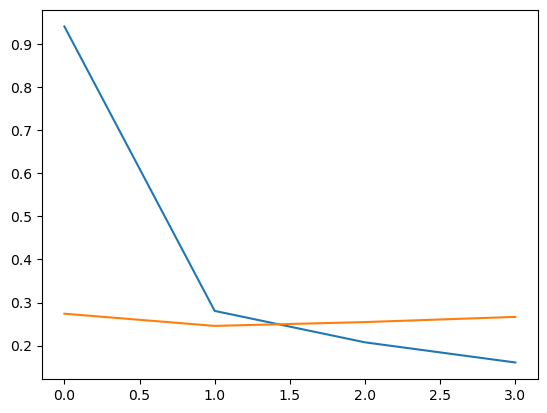

In [30]:
import matplotlib.pyplot as plt

with torch.no_grad():
    plt.plot(train_losses)
    plt.plot(val_losses)

In [31]:
from sklearn.metrics import classification_report
with torch.no_grad():
    print(classification_report(test_labels(model=model, loader=test_loader), y_test, zero_division=True))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      3512
           1       0.94      0.92      0.93      3429
           2       0.91      0.83      0.87      3732
           3       0.96      0.95      0.96      3464
           4       0.75      0.90      0.82      2820
           5       0.98      0.99      0.98      3443

    accuracy                           0.92     20400
   macro avg       0.92      0.92      0.92     20400
weighted avg       0.92      0.92      0.92     20400



In [34]:
torch.save(model.state_dict(), 'model_v2')

In [ ]:
#  precision    recall  f1-score   support

#            0       0.94      0.96      0.95      3068
#            1       0.96      0.89      0.92      3410
#            2       0.85      0.88      0.87      3060
#            3       0.96      0.94      0.95      3305
#            4       0.83      0.84      0.84      3126
#            5       0.96      0.99      0.97      3231

#     accuracy                           0.92     19200
#    macro avg       0.92      0.92      0.92     19200
# weighted avg       0.92      0.92      0.92     19200
